# Clustering of opioid claims of health care provider 

In this notebook, we examine how clustering could be used to help anomaly detection. This in a continuation of the opioid_statistics notebook. In that one, the each health care provider was separated into was speciality. Then using a boxplot, we were able to determine which healthcare providers were outside the normal range. This method does not consider anything other factors that may determine the normal range of opioid use other than speciality. In this notebook, we create clusters for each speciality to see how that affects the number of outliers. Attributes considered are location(longitude and latitude), city median income, temperature (min,max and mean), population, number of opioid claims, and percent of opioid claims. The number of total claims is left out because they can be completely dependent on number of opioid claims and percent of opioid claims. Having attribute that is completely co-dependant from other attributes is a poor practice for clustering.

In [ ]:
#used to stop program under certain conditions
from sys import exit

#dataframes and numerical processes
import pandas as pd
import numpy as np

#importing database from file or online
import csv
from urllib import request
from sodapy import Socrata

#for linear fitting
from sklearn import linear_model
from scipy import stats

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from  matplotlib.patches import Circle
import seaborn as sns

#for clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

#allow for pandas chaining operations without warning messages
pd.options.mode.chained_assignment = None

#import population and opioid data from Data_wrangling notebook
from ipynb.fs.defs.data_wrangling import combine_strings, create_pop_dataframe,add_temperature_to_dataframe,\
                                         add_income_to_dataframe,create_opioid_dataframe
population_df,location_pop=create_pop_dataframe()
population_df,temperature_df= add_temperature_to_dataframe(population_df) 
population_df=add_income_to_dataframe(population_df)
opioid_df,opioid_reduced = create_opioid_dataframe(population_df)

# Standardize and form PCA models for each speciality

Here, the attribuates are being standardized (mean=0 and standard deviation = 1) so clustering does not bias any of the attribuates. That we are going to use principal component analysis (PCA) in order to reduce the number of attributes. Based on our analysis we found that 90% of the variance of the attributes can be explained by 6 of principal components (see cumulative sum).

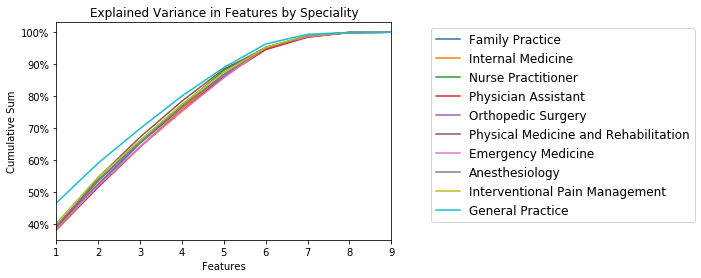

In [2]:
#create a dataframe for the top 10 specialties
specialty_top=opioid_reduced.groupby('specialty description').sum()[['opioid claims','total claims']].sort_values(by='opioid claims',ascending=False)
specialty_list=specialty_top.head(10).index.tolist()
speciality_df = {}
speciality_mat = {}
speciality_standard = {}
pca_coord = {}
fig = plt.figure()
for i in specialty_list:
    speciality_df[i] = opioid_reduced[opioid_reduced['specialty description'] == i]
    speciality_df[i]['zip code'] = speciality_df[i]['zip code'].astype('str')
    speciality_df[i]['label'] = speciality_df[i][['doctor name','city','state_id','zip code']].apply(lambda x:combine_strings(*x),axis=1)
    speciality_df[i].drop(columns=['zip code','specialty description','total claims','doctor name',
                                  'specialty index','city','state_id'],axis=1,inplace=True)
    speciality_mat[i] = np.matrix(speciality_df[i].drop(columns=['label'],axis=1))
    
    #standardized
    scaler = StandardScaler()
    speciality_standard[i] = scaler.fit_transform(speciality_mat[i])
    pca = PCA()
    pca.fit(speciality_standard[i])
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
        
plt.title('Explained Variance in Features by Speciality') 
plt.xlabel('Features')
plt.yticks([.4,.5,.6,.7,.8,.9,1],['40%','50%','60%','70%','80%','90%','100%'])
plt.xticks(np.arange(0,9),np.arange(1,10))
plt.ylabel('Cumulative Sum')
plt.legend(specialty_list,bbox_to_anchor=(1.10, 1.00),prop={'size': 12})
plt.xlim(0,8)
plt.show()
fig.savefig('explained_variance.jpg',bbox_inches='tight')

# Breakdown of the principle components expressed using the original attributes.


In [3]:
pca_6 = {}
for i in specialty_list:
    #6 components 
    pca_6[i] = PCA(n_components=6)
    pca_coord[i] = pca_6[i].fit_transform(speciality_standard[i])
    print('\nPrinciple Components of {}:'.format(i))
    display(pd.DataFrame(pca_6[i].components_,
                         columns=speciality_df[i].drop(columns=['label']).columns))


Principle Components of Family Practice:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.044866,0.017307,0.507163,-0.022528,-0.114761,-0.529531,-0.489458,-0.450823,0.059857
1,0.646203,0.406715,-0.000608,0.319993,-0.354291,-0.023212,-0.093460,0.098799,-0.412374
2,0.196749,0.513291,0.017678,-0.754712,0.194758,0.051278,0.168532,-0.239971,-0.037008
3,0.152713,0.037892,-0.063673,-0.104942,-0.650237,0.068266,0.108405,-0.016679,0.721581
4,-0.060637,0.594643,0.027330,0.406912,0.457017,-0.038468,-0.112713,0.154113,0.479164
5,0.717374,-0.463664,0.043461,-0.022186,0.435942,-0.037146,-0.024428,-0.043878,0.272143



Principle Components of Internal Medicine:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.038169,0.004139,0.510917,0.078185,-0.080622,-0.534540,-0.503299,-0.424208,0.076692
1,0.160843,0.353013,0.010239,-0.813768,0.074664,0.029883,0.163880,-0.373033,0.121284
2,0.700836,0.408108,0.004000,0.177790,-0.393194,-0.009578,-0.061802,0.069233,-0.383856
3,-0.167300,0.323278,0.065287,0.046224,0.683254,-0.050075,-0.085802,0.028431,-0.619346
4,-0.317494,0.772588,-0.005654,0.250203,-0.058418,0.024784,-0.029903,0.172607,0.452722
5,0.593558,-0.074235,0.047886,0.149149,0.598093,-0.022025,-0.064944,0.111258,0.492790



Principle Components of Nurse Practitioner:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,0.013244,0.068465,0.507369,0.045741,-0.073926,-0.528832,-0.493325,-0.449241,0.072840
1,0.686026,0.707558,-0.016722,-0.036795,0.154279,0.028569,0.025138,0.024524,0.035280
2,-0.097430,-0.037510,0.071053,-0.846967,0.415090,0.036321,0.137044,-0.269305,0.042118
3,0.251205,-0.122520,0.017776,-0.214640,-0.399538,0.002106,0.034250,-0.123002,-0.836397
4,0.210401,-0.089916,-0.039507,-0.306023,-0.738884,0.068105,0.125963,-0.094851,0.526293
5,0.642009,-0.685418,0.025150,0.100968,0.299134,-0.031836,-0.041666,0.006963,0.122146



Principle Components of Physician Assistant:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.012436,0.073117,0.503930,0.056739,-0.132342,-0.532055,-0.489964,-0.440731,0.049298
1,0.650293,0.657106,0.015058,-0.280531,0.195857,0.025503,0.071755,-0.083803,0.123385
2,0.197585,0.279030,-0.067785,0.841495,-0.196211,-0.017855,-0.155292,0.327089,0.021757
3,-0.049474,-0.031924,-0.054304,-0.081508,-0.447858,0.054203,0.100547,-0.020880,0.879136
4,0.461823,-0.247214,-0.023202,-0.163212,-0.737048,0.042514,0.058308,-0.039503,-0.385255
5,0.567168,-0.650106,0.046801,0.141917,0.400491,-0.060064,-0.094480,0.032468,0.243661



Principle Components of Orthopedic Surgery:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.111863,0.070737,0.503677,0.011388,-0.127542,-0.525278,-0.490351,-0.439123,0.056608
1,0.629356,0.457627,-0.010155,0.315605,-0.440202,-0.012076,-0.063500,0.084537,-0.299460
2,0.087084,0.514152,-0.004265,-0.782191,0.088945,0.061694,0.164708,-0.260625,-0.097220
3,0.140974,-0.029974,-0.064464,-0.116245,-0.504663,0.054800,0.114840,-0.058035,0.829045
4,0.324426,0.339742,0.060087,0.231330,0.707905,-0.058030,-0.100249,0.080572,0.448509
5,0.674992,-0.634363,0.045042,-0.248782,0.148282,-0.063206,0.001717,-0.209853,-0.089581



Principle Components of Physical Medicine and Rehabilitation:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.081752,0.019090,0.503772,0.007161,-0.090853,-0.529788,-0.498612,-0.436537,0.104918
1,0.654536,0.679949,0.014307,-0.050588,-0.309121,0.009974,0.013340,-0.015648,0.102029
2,-0.051532,0.049971,-0.008819,-0.907532,0.166423,0.058440,0.177836,-0.328220,-0.026249
3,0.259856,0.096386,0.090231,0.081090,0.478329,-0.079400,-0.105942,-0.016703,-0.813549
4,0.060448,0.231077,0.067728,0.086759,0.793293,-0.015748,-0.047381,0.114985,0.534609
5,0.699723,-0.682439,0.009469,-0.034881,0.048296,-0.023163,0.011682,-0.104592,0.171502



Principle Components of Emergency Medicine:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.096885,0.020524,0.508498,0.048911,-0.073467,-0.531772,-0.497829,-0.437443,0.043142
1,-0.103533,-0.241647,-0.024039,-0.765439,-0.063348,0.044208,0.186951,-0.313091,0.453287
2,0.637538,-0.424770,-0.012796,0.130030,-0.625706,-0.015787,-0.024932,-0.002851,0.060478
3,0.202536,-0.550772,0.049228,-0.215131,0.478437,-0.040608,-0.018265,-0.107275,-0.603765
4,0.373777,0.649791,0.010959,-0.415685,-0.191273,0.009845,0.057143,-0.174438,-0.441330
5,0.626241,0.186582,0.046719,0.078897,0.576099,-0.047621,-0.045802,-0.006433,0.477813



Principle Components of Anesthesiology:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.105218,0.011785,0.502401,0.095677,-0.091225,-0.525424,-0.498866,-0.435892,0.062998
1,0.606709,0.623364,-0.002283,0.287726,-0.375709,-0.003590,-0.042149,0.077655,0.107485
2,0.018161,0.144639,-0.005119,-0.718927,-0.163370,0.031446,0.116666,-0.212877,0.612586
3,0.308457,0.329616,0.085540,-0.454097,0.508368,-0.045767,-0.017067,-0.176256,-0.539256
4,-0.082372,0.273875,0.048574,0.279055,0.726684,-0.018376,-0.062159,0.162129,0.528601
5,0.718507,-0.633914,0.016446,0.035830,0.178043,-0.047190,-0.027297,-0.084525,0.196292



Principle Components of Interventional Pain Management:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.163967,-0.066022,0.499979,0.005968,-0.093449,-0.518401,-0.488388,-0.441412,0.088891
1,0.561862,0.624702,0.029622,0.347032,-0.399408,-0.067603,-0.088611,-0.007406,-0.027297
2,0.219431,0.331749,0.065329,-0.874168,0.056533,0.022148,0.099551,-0.232367,-0.075923
3,-0.206706,0.056867,-0.072068,-0.129929,-0.417716,0.082462,0.110326,0.027382,0.858927
4,0.155334,0.294822,0.066732,0.138321,0.803400,-0.056834,-0.094967,0.068133,0.450580
5,0.730792,-0.632818,-0.013626,-0.039905,-0.008307,-0.028509,0.016872,-0.133642,0.211377



Principle Components of General Practice:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,0.073168,0.137952,0.467878,-0.302932,0.022261,-0.469049,-0.450545,-0.424546,0.247397
1,0.501630,0.198309,-0.021857,0.276749,-0.752534,-0.083606,-0.105475,-0.031558,-0.215766
2,0.632404,0.551321,-0.022140,-0.185494,0.439456,0.149828,0.123874,0.160872,0.066458
3,0.570006,-0.789278,0.047649,-0.098859,0.169895,-0.026349,-0.032642,-0.018210,-0.095571
4,0.080774,-0.115626,-0.094792,-0.204303,-0.344237,0.173397,0.180870,0.115594,0.857169
5,-0.067400,0.020915,-0.087958,-0.809732,-0.275220,0.154557,0.253230,-0.189562,-0.363214


# K means clusters

Here the best number of clusters using a K-means is determined. Both an elbow plot and the mean silhouette score is used to optimize the number of clusters. The elbow plot indicated that number of clusters for each speciality should be larger numbers. It was also found that normal range of each cluster was smaller with greater number of clusters which makes it easier identify outliers. The number of clusters was restricted to greater than 5.  The number of clusters was then determine by average silhouette score.


 For  Family Practice
For n_clusters = 2 The average silhouette_score is : 0.29699423675717873
For n_clusters = 3 The average silhouette_score is : 0.26169420519012954
For n_clusters = 4 The average silhouette_score is : 0.2682237205734301
For n_clusters = 5 The average silhouette_score is : 0.2790257188681
For n_clusters = 6 The average silhouette_score is : 0.28936948277807717
For n_clusters = 7 The average silhouette_score is : 0.27679253535746773
For n_clusters = 8 The average silhouette_score is : 0.2684272863982932
For n_clusters = 9 The average silhouette_score is : 0.25601298213970375
For n_clusters = 10 The average silhouette_score is : 0.2649049504378814
For n_clusters = 11 The average silhouette_score is : 0.2679848615630117
For n_clusters = 12 The average silhouette_score is : 0.2693726679639189
For n_clusters = 13 The average silhouette_score is : 0.22480877324633802
For n_clusters = 14 The average silhouette_score is : 0.2263596489694629
silhouete_max = 0.289369482778077

For n_clusters = 3 The average silhouette_score is : 0.27821161853289617
For n_clusters = 4 The average silhouette_score is : 0.23047882912401346
For n_clusters = 5 The average silhouette_score is : 0.223869649823379
For n_clusters = 6 The average silhouette_score is : 0.21983839461733948
For n_clusters = 7 The average silhouette_score is : 0.24102939523294392
For n_clusters = 8 The average silhouette_score is : 0.2375939246353648
For n_clusters = 9 The average silhouette_score is : 0.2452347752771749
For n_clusters = 10 The average silhouette_score is : 0.22859103688255894
For n_clusters = 11 The average silhouette_score is : 0.23699796654303174
For n_clusters = 12 The average silhouette_score is : 0.23188868461051032
For n_clusters = 13 The average silhouette_score is : 0.22928614027581568
For n_clusters = 14 The average silhouette_score is : 0.21499049931887207
silhouete_max = 0.2452347752771749 k = 9

 For  General Practice
For n_clusters = 2 The average silhouette_score is : 0.401

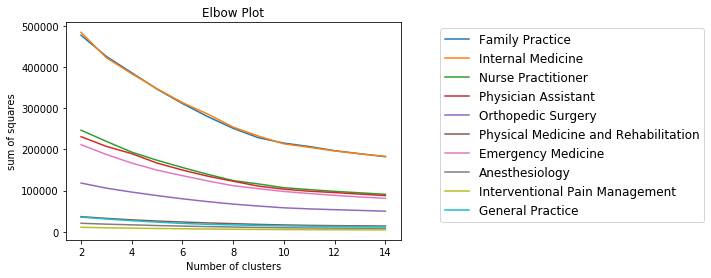

In [4]:
fig = plt.figure()

ks = range(2,15)
cluster_n = {}
silhouete_max = {}
for i in specialty_list:
    sum_of_squares = []
    silhouete_max[i] = 0.0
    cluster_n[i] = 2
    print('\n For ',i)
    for k in ks:
        kmeans = KMeans(n_clusters=k,random_state=1)
        cluster_labels = kmeans.fit_predict(pca_coord[i])
        silhouette_avg = silhouette_score(pca_coord[i], cluster_labels,sample_size=10000)
        print("For n_clusters =", k,
              "The average silhouette_score is :", silhouette_avg)
        sum_of_squares.append(kmeans.inertia_)
        if(silhouette_avg > silhouete_max[i]) & (k > 5):
            silhouete_max[i] = silhouette_avg
            cluster_n[i] = k
    print('silhouete_max =',silhouete_max[i], 'k =',cluster_n[i])
    plt.plot(ks,sum_of_squares)
plt.title('Elbow Plot')
plt.legend(specialty_list,bbox_to_anchor=(1.10, 1.00),prop={'size': 12})
plt.xlabel('Number of clusters')
plt.ylabel('sum of squares')

fig.savefig('Elbow_Plot.jpg',bbox_inches='tight')
plt.show()



# Create clusters for the 10 specilities that prescribed opioids.
Here we create the clusters of the 10 top specialties that prescribed opioid. In the next series of cells boxplots for each clusters of the specialties is made. Using the boxplot we can visualize which normal range of opioid prescription for which cluster. The figures also contain a boxplot of the normal range of opioid prescription without k-means clustering.

There were 3 distinct patterns of clustering for the specialties examined. The first major pattern is that within a speciality, the clusters have similar medians and distribution of percent of opioids (though not identical). This is a similar range to that of the total data within the speciality without clustering. The exception is a single cluster that has a completely different median and range. The specialities that follow this pattern are family practice, internal medicine, emergency medicine and general practice. It is of interest that all these specialities prescribed a broad set of drugs. A significant number of healthcare providers that were considered outliers without clustering are no longer outliers when placed in that cluster with a different range. This has the effect of lowering the number of outliers. The cluster of a different range for emergency medicine range of values was lower than the other clusters. Since only higher opioid claim outliers are considered, clustering did not lower the number of outliers for emergency medicine. This clustering pattern would suggest that a lower number of clusters would sufficance, this pattern was only seen for large cluster numbers (k>5).

The second cluster patterns seen is the clusters having broad ranges in their boxplot. The range of the distribute of unclustered boxplot for these specialities covers close to 0% to 100% opioid claims which makes use of percent opioid claims useless for outlier detection. The boxplot of the clusters cover a smaller range but it is still wide. Outlier detection to detect opioid fraud is difficult with a wide range since it is more likely that a case of will fall into the within the boxplots range. Specialities that have this pattern are orthopedic surgery, physical medicine and rehabilitation, anesthesiology, and interventional pain management. All specialities that treat pain and would be expected heavily prescribe opioids.

The last cluster patterns seen is there two distinct sets of similar clusters. One with a similar percent opioid boxplot to the uncluster. Both nurse practitioner and physician assistant fall into this pattern.
Nurse practitioners have 10 clusters, 8 with similar boxplots to the unclustered and 2 similar to each other. Physician assistant have 11 clusters, 8 with similar boxplots to the unclustered and 3 similar to each other. 

In [7]:
for i, k in cluster_n.items():specialties
    kmeans = KMeans(n_clusters=k,random_state=1)
    speciality_df[i]['cluster'] = kmeans.fit_predict(pca_coord[i])
    speciality_df[i]['cluster'] = speciality_df[i]['cluster'].apply(lambda x: 'c' + str(x).zfill(2)) 

# Family Practice

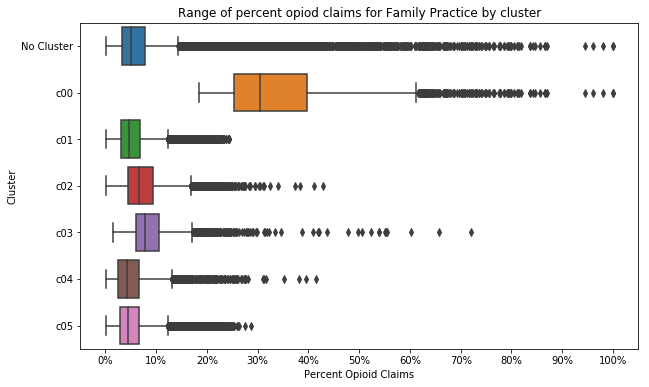

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,5.08,3.26,7.72,14.40,4917,77926,6.31
c00,30.40,25.29,39.70,61.31,139,2156,6.45
c01,4.63,3.08,6.78,12.31,1516,33966,4.46
c02,6.70,4.44,9.38,16.80,358,10192,3.51
c03,7.88,6.08,10.52,17.17,201,4126,4.87
c04,4.26,2.43,6.69,13.06,202,4060,4.98
c05,4.51,2.93,6.66,12.25,1161,23426,4.96


total number of Family Practice outliers with clustering:3577
total number of Family Practice outliers without clustering:4917


In [8]:
specility = 'Family Practice'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Internal Medicine

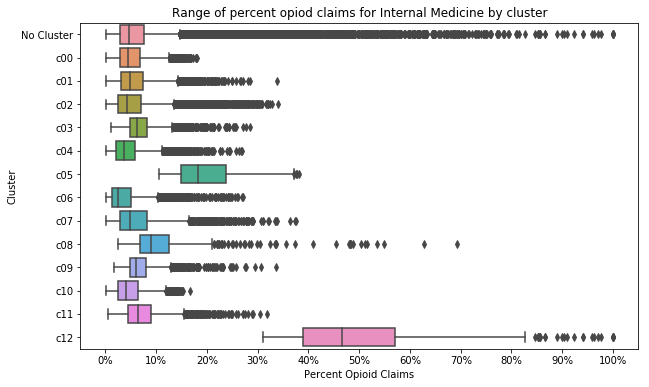

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,4.74,2.85,7.56,14.62,4663,79871,5.84
c00,4.46,2.93,6.80,12.61,264,12693,2.08
c01,4.91,2.99,7.48,14.23,268,8528,3.14
c02,4.23,2.52,6.94,13.57,577,10406,5.54
c03,6.13,4.79,8.17,13.25,156,4156,3.75
c04,3.63,2.17,5.80,11.24,357,8019,4.45
c05,18.18,14.82,23.75,37.15,4,2966,0.13
c06,2.55,1.32,4.96,10.42,220,3949,5.57
c07,4.92,2.81,8.28,16.48,167,3989,4.19


total number of Internal Medicine outliers with clustering:2649
total number of Internal Medicine outliers without clustering:4663


In [11]:
specility = 'Internal Medicine'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Nurse Practitioner

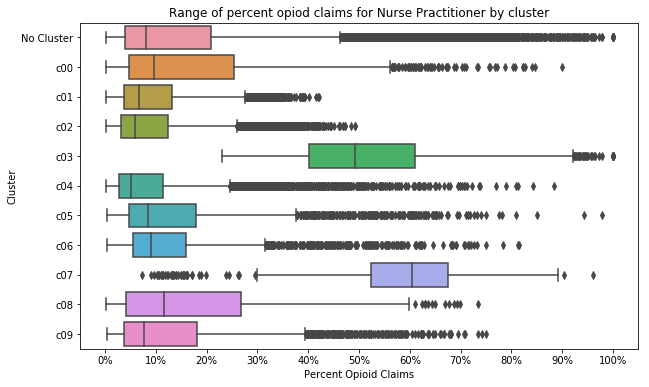

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,7.97,3.85,20.85,46.35,3321,40157,8.27
c00,9.69,4.66,25.36,56.41,63,1366,4.61
c01,6.67,3.65,13.25,27.64,493,10707,4.60
c02,5.92,3.19,12.32,26.02,745,9047,8.23
c03,49.17,40.18,60.98,92.17,40,3877,1.03
c04,5.05,2.68,11.46,24.62,631,5164,12.22
c05,8.52,4.72,17.91,37.70,229,2490,9.20
c06,9.03,5.47,15.89,31.52,218,2319,9.40
c07,60.36,52.31,67.43,90.11,2,490,0.41


total number of Nurse Practitioner outliers with clustering:2621
total number of Nurse Practitioner outliers without clustering:3321


In [12]:
specility = 'Nurse Practitioner'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Physician Assistant

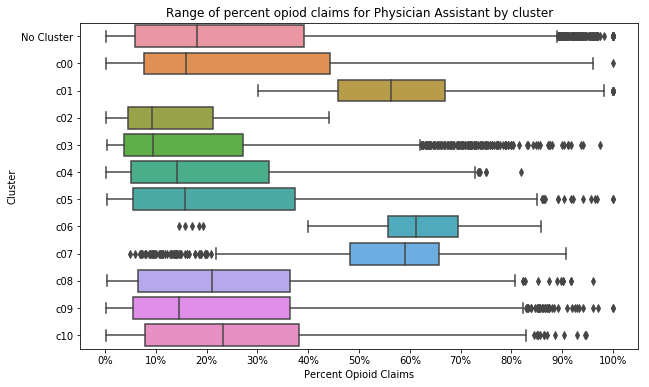

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,18.18,5.87,39.13,89.01,146,37970,0.38
c00,16.02,7.69,44.27,99.13,1,2672,0.04
c01,56.21,45.79,66.97,98.73,14,5113,0.27
c02,9.22,4.47,21.32,46.60,0,9303,0.00
c03,9.35,3.77,27.15,62.22,136,4242,3.21
c04,14.17,5.08,32.34,73.23,6,6866,0.09
c05,15.68,5.51,37.37,85.15,15,1300,1.15
c06,61.14,55.76,69.51,90.13,0,115,0.00
c07,59.07,48.14,65.75,92.17,0,536,0.00


total number of Physician Assistant outliers with clustering:234
total number of Physician Assistant outliers without clustering:146


In [13]:
specility = 'Physician Assistant'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Orthopedic Surgery

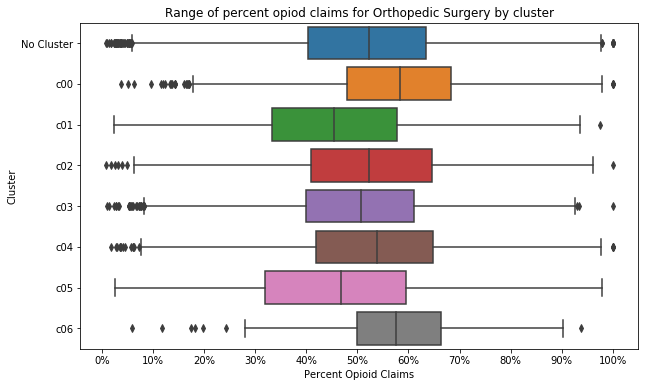

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,52.23,40.36,63.33,97.79,12,19475,0.06
c00,58.33,47.93,68.42,99.14,4,1974,0.20
c01,45.45,33.23,57.69,94.39,1,2761,0.04
c02,52.30,40.94,64.56,99.99,1,1847,0.05
c03,50.64,40.00,61.16,92.90,3,4199,0.07
c04,53.76,41.82,64.73,99.10,4,7192,0.06
c05,46.78,31.90,59.52,100.00,0,994,0.00
c06,57.61,49.85,66.40,91.23,1,508,0.20


total number of Orthopedic Surgery outliers with clustering:14
total number of Orthopedic Surgery outliers without clustering:12


In [14]:
specility = 'Orthopedic Surgery'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Physical Medicine and Rehabilitation

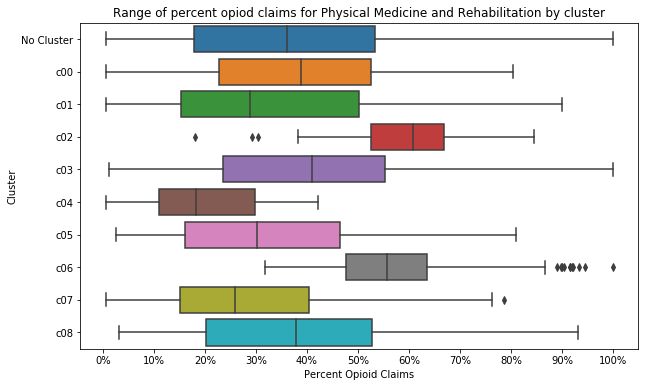

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,36.11,17.87,53.45,100.00,0,6072,0.00
c00,38.77,22.87,52.66,97.35,0,617,0.00
c01,28.83,15.28,50.31,100.00,0,903,0.00
c02,60.72,52.53,66.78,88.16,0,162,0.00
c03,40.98,23.61,55.29,100.00,0,614,0.00
c04,18.23,11.06,29.78,57.86,0,1466,0.00
c05,30.28,16.14,46.46,91.95,0,286,0.00
c06,55.71,47.69,63.64,87.58,11,1252,0.88
c07,25.90,15.11,40.43,78.41,1,354,0.28


total number of Physical Medicine and Rehabilitation outliers with clustering:12
total number of Physical Medicine and Rehabilitation outliers without clustering:0


In [15]:
specility = 'Physical Medicine and Rehabilitation'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Emergency Medicine

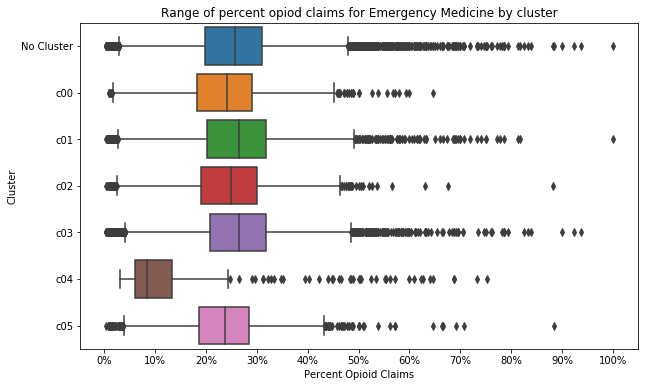

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,25.64,19.78,31.03,47.90,371,34857,1.06
c00,24.07,18.18,29.13,45.55,25,2082,1.20
c01,26.42,20.13,31.76,49.21,95,10399,0.91
c02,25.00,19.01,30.00,46.48,27,3970,0.68
c03,26.42,20.82,31.90,48.54,159,13558,1.17
c04,8.38,6.12,13.43,24.40,41,250,16.40
c05,23.70,18.63,28.50,43.32,46,4598,1.00


total number of Emergency Medicine outliers with clustering:393
total number of Emergency Medicine outliers without clustering:371


In [16]:
specility = 'Emergency Medicine'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Anesthesiology

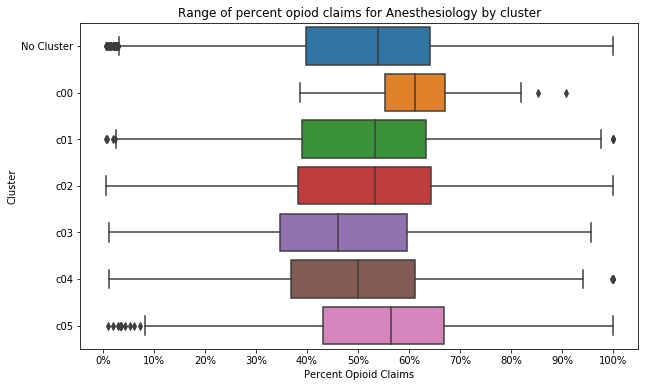

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,53.95,39.79,64.21,100.00,0,3476,0.00
c00,61.24,55.25,67.07,84.81,2,210,0.95
c01,53.45,39.02,63.35,99.84,4,924,0.43
c02,53.28,38.34,64.34,100.00,0,1350,0.00
c03,46.11,34.78,59.55,96.71,0,170,0.00
c04,50.00,36.96,61.25,97.69,4,361,1.11
c05,56.42,43.08,66.82,100.00,0,461,0.00


total number of Anesthesiology outliers with clustering:10
total number of Anesthesiology outliers without clustering:0


In [18]:
specility = 'Anesthesiology'

this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# Interventional Pain Management

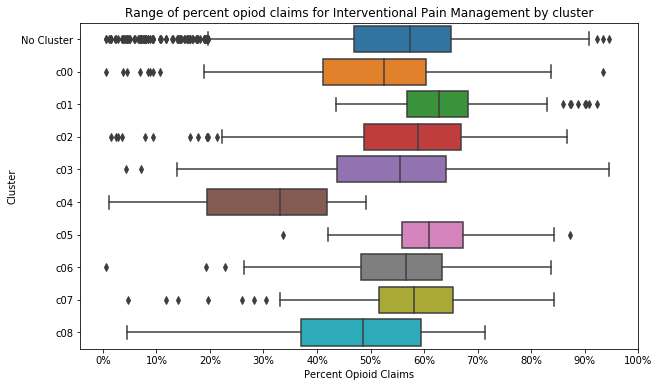

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,57.42,46.90,65.05,92.26,3,1833,0.16
c00,52.46,41.19,60.38,89.15,1,172,0.58
c01,62.76,56.85,68.21,85.26,8,463,1.73
c02,58.79,48.77,66.88,94.05,0,356,0.00
c03,55.48,43.81,64.12,94.59,0,150,0.00
c04,33.01,19.39,41.81,75.45,0,190,0.00
c05,60.92,55.95,67.29,84.31,1,121,0.83
c06,56.55,48.14,63.35,86.17,0,113,0.00
c07,58.09,51.50,65.40,86.24,0,206,0.00


total number of Interventional Pain Management outliers with clustering:10
total number of Interventional Pain Management outliers without clustering:3


In [19]:
specility = 'Interventional Pain Management'

this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# General Practice

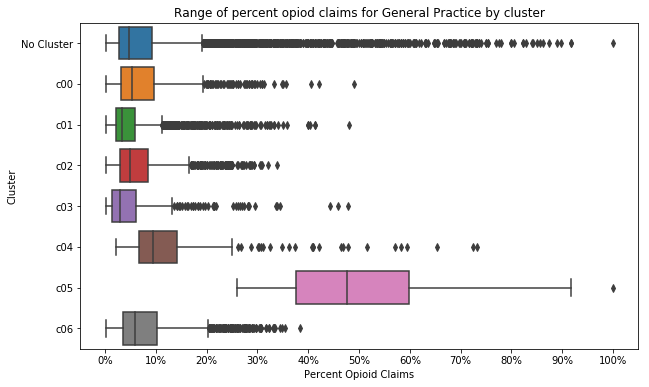

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,4.74,2.66,9.28,19.20,756,6712,11.26
c00,5.31,3.11,9.60,19.33,55,455,12.09
c01,3.39,2.22,5.82,11.20,259,2453,10.56
c02,4.96,2.90,8.45,16.76,101,1232,8.20
c03,2.86,1.37,6.15,13.33,41,534,7.68
c04,9.52,6.78,14.16,25.24,25,257,9.73
c05,47.65,37.54,59.78,93.14,1,343,0.29
c06,5.88,3.48,10.18,20.24,116,1438,8.07


total number of General Practice outliers with clustering:598
total number of General Practice outliers without clustering:756


In [20]:
specility = 'General Practice'
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

fig = plt.figure(figsize=(10,6))
c_list = sorted(copy_df['cluster'].unique())

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# The following cell exists only to create figure for documentation.

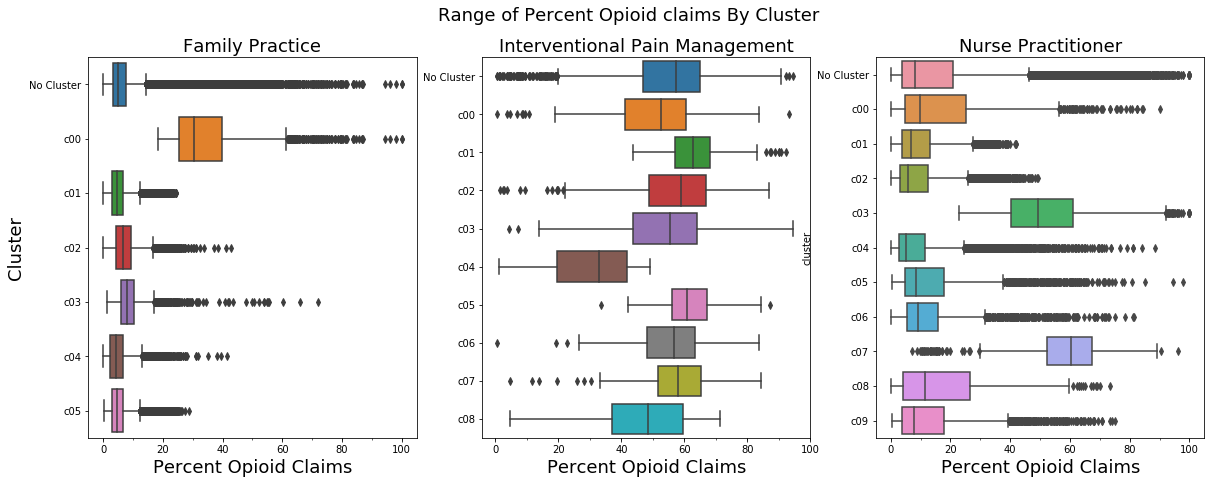

In [111]:
fig = plt.figure(figsize=(20,7))

plt.suptitle('Range of Percent Opioid claims By Cluster',size=18)

#Family Practive
ax1 = fig.add_subplot(1,3,1)
specility = 'Family Practice'
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax1)
ax1.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title =  specility
ax1.set_title(the_title,size=18)
ax1.set_ylabel('Cluster',size=18)
plt.xlabel('Percent Opioid Claims',size=18)

#Interventional Pain Management
ax2 = fig.add_subplot(1,3,2)
specility = 'Interventional Pain Management'
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax2)
ax2.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title =  specility
ax2.set_title(the_title,size=18)
ax2.set_ylabel('')
plt.xlabel('Percent Opioid Claims',size=18)

#Nurse Practitioner
ax3 = fig.add_subplot(1,3,3)
specility ='Nurse Practitioner'
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax3)
ax3.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title =  specility
ax3.set_title(the_title,size=18)
ax2.set_ylabel('')
plt.xlabel('Percent Opioid Claims',size=18)


figure_name = 'pattern.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()


# Check against known cases for opioid fraud

In 2018, the United States Department of Justice had a massive crackdown on the healthcare fraud. 601 individuals were prosecuted, including 165 doctors, nurses and other licensed medical professionals. Of these charged, 162 were prosecuted for prescribing and distributing opioid and other narcotics. There is complete list of health care provider that have been changed. From various online articles on specific cases from this round of arrests, we were able to find 5 healthcare providers who were persecuted for opioid fraud and were on the 2013 Medicare Part D database. Using the cluster boxplot, we examined whether these medical professionals were marked as outliers.

These five healthcare providers are Bothra Rajendra(general surgery), Eric Backo (Physical Medicine and Rehabilitation), Madhu Garg(Family Practice), Lawrence Miller (Family Practice), and Samson Orusa (Internal Medicine). General surgery, speciality practiced by Bothra Rajendra, was not one of the fields previously examined so the clustering process that was described was performed. The field of general surgery's boxplots has a broad range of values in the distribution which makes outlier detection more difficult. Without clustering Bothra Rajendra percent opioid claims fails right within the whiskers (without clustering the boxplot distribution covers 0% to 100%). Both Madhu Garg and Samson Orusa were clear outliers within their cluster. Without clustering, Madhu Garg is below edge of the distribution. Lawence Miller is just below the edge of the distribution within his cluster. Finally Eric Backos failed to be marked as an outlier, the median percent opioid claims of this cluster is high than that of Eric Backos. The final results are of the known cases of fraud, two where detected as an outlier, two were borderline, and failed to be detected.


source:https://www.justice.gov/opa/pr/national-health-care-fraud-takedown-results-charges-against-601-individuals-responsible-over
 
source of Bothra Rajendra and Eric Backos opiod fraud charges: https://www.detroitnews.com/story/news/local/macomb-county/2018/12/06/feds-allege-six-detroit-area-doctors-fueled-opioid-crisis-health-care-fraud-conspiracy/2225239002/


of Madhu Garg: https://patch.com/california/glendora/ex-glendora-doctor-sentenced-prison-selling-pain-pills-addicts-la

of Lawrence Miller: http://www.fox29.com/news/local-news/prosecutors-4-area-doctors-arrested-in-pill-mill-investigation


of Samson Orusa: https://www.theleafchronicle.com/story/news/crime/2018/12/14/who-samson-orusa-clarksville-doctor-charged-opioid-fraud-scheme/2312021002/



In [10]:
#doctor 1
display(opioid_df[opioid_df['doctor name'].str.lower().str.contains('bothra') &
         opioid_df['doctor name'].str.lower().str.contains('rajendra')])

#doctor 2
display(opioid_df[opioid_df['doctor name'].str.lower().str.contains('backos') &
        opioid_df['doctor name'].str.lower().str.contains('eric')])

#doctor 3
display(opioid_df[opioid_df['doctor name'].str.lower().str.contains('madhu') &
        opioid_df['doctor name'].str.lower().str.contains('garg') &
        (opioid_df['specialty description'] == 'Family Practice')])

#doctor 4
display(opioid_df[opioid_df['doctor name'].str.lower().str.contains('lawrence') &
        (opioid_df['doctor name'].str.lower().str.contains('miller'))  &
        (opioid_df['state_id']=='PA')])

#doctor 5
display(opioid_df[opioid_df['doctor name'].str.lower().str.contains('samson') &
        opioid_df['doctor name'].str.lower().str.contains('orusa')])




,zip code,specialty description,total claims,opioid claims,percent opioid claims,doctor name,specialty index,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
100188,48093,General Surgery,1999,1420,71.035518,RAJENDRA BOTHRA,132,Warren,MI,42.5142,-83.0149,134056.0,10.897222,-3.801,22.732,98122.0


,zip code,specialty description,total claims,opioid claims,percent opioid claims,doctor name,specialty index,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
47127,48093,Physical Medicine and Rehabilitation,11263,5758,51.123147,ERIC BACKOS,102,Warren,MI,42.5142,-83.0149,134056.0,10.897222,-3.801,22.732,98122.0


,zip code,specialty description,total claims,opioid claims,percent opioid claims,doctor name,specialty index,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
312761,91706,Family Practice,194,27,13.917526,MADHU GARG,127,Baldwin Park,CA,34.0964,-117.9682,76571.0,18.120667,8.813,25.09,135612.5


,zip code,specialty description,total claims,opioid claims,percent opioid claims,doctor name,specialty index,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
697077,37042,Internal Medicine,5878,3142,53.453556,SAMSON ORUSA,158,Clarksville,TN,36.5691,-87.417,151785.0,16.172444,4.823,24.51,107206.75


,zip code,specialty description,total claims,opioid claims,percent opioid claims,doctor name,specialty index,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
627862,19446,Family Practice,6088,549,9.01774,LAWRENCE MILLER,127,Lansdale,PA,40.232,-75.3037,55138.0,14.013667,1.662,25.683,76203.833333


# Does clustering help determine if  Rajendra Bothra is an outlier?

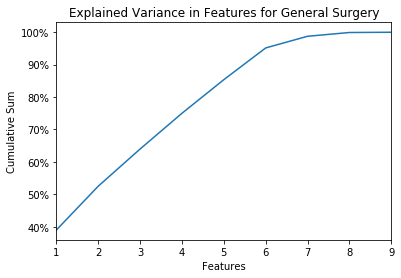


Principle Components of General Surgery:


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,-0.045128,0.000547,0.505313,0.019527,-0.112395,-0.528444,-0.497086,-0.446710,0.060911
1,0.121561,-0.478040,-0.022409,0.709949,-0.275322,-0.040791,-0.133719,0.213684,-0.333413
2,0.725870,0.164198,-0.035788,-0.080509,-0.589213,0.035777,0.063191,-0.041958,0.290145
3,0.512595,-0.094080,0.053329,-0.332923,0.302656,-0.030855,-0.015225,-0.125839,-0.711402
4,-0.028652,-0.853298,-0.021363,-0.402614,-0.059212,0.036084,0.096612,-0.137774,0.274562
5,0.438975,-0.084852,0.056293,0.304553,0.682170,-0.057693,-0.091197,0.094339,0.467202


For n_clusters = 2 The average silhouette_score is : 0.2802783145091015
For n_clusters = 3 The average silhouette_score is : 0.27762516081310057
For n_clusters = 4 The average silhouette_score is : 0.29464569322624373
For n_clusters = 5 The average silhouette_score is : 0.1770957938790413
For n_clusters = 6 The average silhouette_score is : 0.21075646564194989
For n_clusters = 7 The average silhouette_score is : 0.20485775255607513
For n_clusters = 8 The average silhouette_score is : 0.23799897128675299
For n_clusters = 9 The average silhouette_score is : 0.22732477406739646
For n_clusters = 10 The average silhouette_score is : 0.2350700767245193
For n_clusters = 11 The average silhouette_score is : 0.25367264904558484
For n_clusters = 12 The average silhouette_score is : 0.21364562049084498
For n_clusters = 13 The average silhouette_score is : 0.22276210302785746
For n_clusters = 14 The average silhouette_score is : 0.22616985139337611
silhouete_max = 0.25367264904558484 k = 11


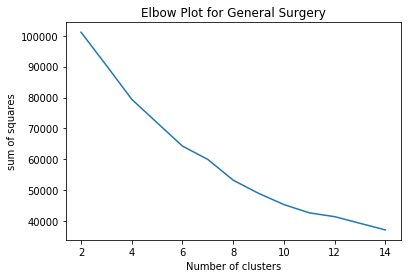

In [63]:
#cumulative plot of PCA 
df_this = opioid_reduced[opioid_reduced['specialty description'] == 'General Surgery']
df_this['zip code'] = df_this['zip code'].astype('str')
df_this['label'] = df_this[['doctor name','city','state_id','zip code']].apply(lambda x:combine_strings(*x),axis=1)
df_this.drop(columns=['zip code','specialty description','total claims','doctor name',
                                  'specialty index','city','state_id'],axis=1,inplace=True)
mat_this = np.matrix(df_this.drop(columns=['label'],axis=1))
#standardized
scaler = StandardScaler()
standard_GS = scaler.fit_transform(mat_this)
pca = PCA()
pca.fit(standard_GS)
plt.plot(np.cumsum(pca.explained_variance_ratio_))    
plt.title('Explained Variance in Features for General Surgery') 
plt.xlabel('Features')
plt.yticks([.4,.5,.6,.7,.8,.9,1],['40%','50%','60%','70%','80%','90%','100%'])
plt.xticks(np.arange(0,9),np.arange(1,10))
plt.ylabel('Cumulative Sum')
plt.xlim(0,8)
plt.show()

#make pca varibles
pca_GS = PCA(n_components=6)
pca_GS_coord = pca_GS.fit_transform(standard_GS)
print('\nPrinciple Components of General Surgery:')
display(pd.DataFrame(pca_GS.components_,columns=df_this.drop(columns=['label']).columns))

#elbow plot and silhouette score
ks = range(2,15)
#cluster_n = {}
silhouete_max = 0.0
cluster_n = 2
sum_of_squares = []
for k in ks:
    kmeans = KMeans(n_clusters=k,random_state=1)
    cluster_labels = kmeans.fit_predict(pca_GS_coord)
    silhouette_avg = silhouette_score(pca_GS_coord, cluster_labels,sample_size=1000)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    sum_of_squares.append(kmeans.inertia_)
    if(silhouette_avg > silhouete_max) & (k > 5):
        silhouete_max = silhouette_avg
        cluster_n = k
print('silhouete_max =',silhouete_max, 'k =',cluster_n)
plt.plot(ks,sum_of_squares)
plt.title('Elbow Plot for General Surgery')
plt.xlabel('Number of clusters')
plt.ylabel('sum of squares')
plt.show()    
    
#set k means labels
GS_df = df_this
kmeans = KMeans(n_clusters=cluster_n,random_state=1)
GS_df['cluster'] = kmeans.fit_predict(pca_GS_coord)
GS_df['cluster'] = GS_df['cluster'].apply(lambda x: 'c' + str(x).zfill(2)) 

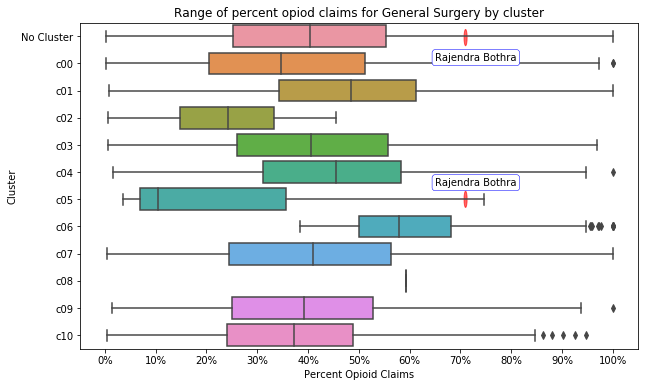

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,40.33,25.22,55.26,100.00,0,16660,0.00
c00,34.62,20.52,51.25,97.34,2,528,0.38
c01,48.45,34.38,61.19,100.00,0,1521,0.00
c02,24.30,14.86,33.33,61.04,0,3090,0.00
c03,40.65,26.06,55.78,100.00,0,2558,0.00
c04,45.45,31.20,58.33,99.03,1,769,0.13
c05,10.38,6.96,35.75,78.92,0,59,0.00
c06,57.89,50.00,68.18,95.45,13,2810,0.46
c07,41.03,24.44,56.25,100.00,0,715,0.00


total number of General Surgery outliers with clustering:22
total number of General Surgery outliers without clustering:0


In [72]:
specility = 'General Surgery'


this_df = GS_df
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])


c_list = sorted(copy_df['cluster'].unique())

#create figure
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

#Ellipse to mark datapoint examined for unclustered
ells = Circle((71, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#Ellipse to mark datapoint examined for clustered
ells = Circle((71, 6), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#add textbox to mark healthcare provider's name
text = 'Rajendra Bothra'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax.text(s=text,x=65,y=5.5,bbox=bbox_props)
ax.text(s=text,x=65,y=0.9,bbox=bbox_props)

#boxplot
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax)
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')


plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

# How well did the cluster do to determine if Rajendra Bothra is an outlier


In [151]:


display(GS_df[GS_df['label'].str.lower().str.contains('bothra') &
         GS_df['label'].str.lower().str.contains('rajendra')])

,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income,label,cluster
100188,1420,71.035518,42.5142,-83.0149,134056.0,10.897222,-3.801,22.732,98122.0,RAJENDRA BOTHRA Warren MI 48093,c05


# Does clustering help determine if Eric Backos is an outlier?

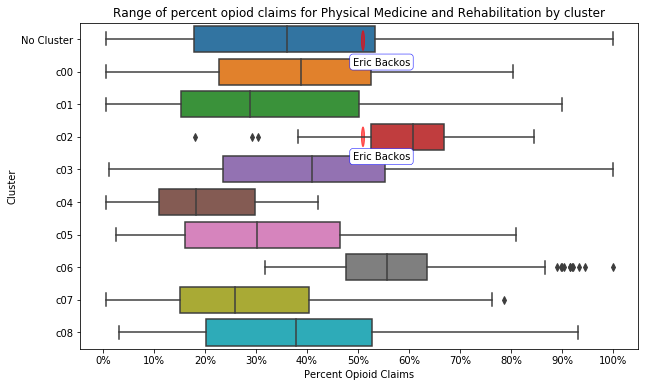

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,36.11,17.87,53.45,100.00,0,6072,0.00
c00,38.77,22.87,52.66,97.35,0,617,0.00
c01,28.83,15.28,50.31,100.00,0,903,0.00
c02,60.72,52.53,66.78,88.16,0,162,0.00
c03,40.98,23.61,55.29,100.00,0,614,0.00
c04,18.23,11.06,29.78,57.86,0,1466,0.00
c05,30.28,16.14,46.46,91.95,0,286,0.00
c06,55.71,47.69,63.64,87.58,11,1252,0.88
c07,25.90,15.11,40.43,78.41,1,354,0.28


total number of Physical Medicine and Rehabilitation outliers with clustering:12
total number of Physical Medicine and Rehabilitation outliers without clustering:0


In [21]:
specility = 'Physical Medicine and Rehabilitation'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

c_list = sorted(copy_df['cluster'].unique())

#create figure
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

#Ellipse to mark datapoint examined for unclustered
ells = Circle((51, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#Ellipse to mark datapoint examined for clustered
ells = Circle((51, 3), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#add textbox to mark healthcare provider's name
text = 'Eric Backos'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax.text(s=text,x=49,y=3.7,bbox=bbox_props)
ax.text(s=text,x=49,y=0.8,bbox=bbox_props)

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

In [123]:
display(speciality_df['Physical Medicine and Rehabilitation'][speciality_df['Physical Medicine and Rehabilitation']['label'].str.lower().str.contains('backos') &
        speciality_df['Physical Medicine and Rehabilitation']['label'].str.lower().str.contains('eric')])

,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income,label,cluster
47127,5758,51.123147,42.5142,-83.0149,134056.0,10.897222,-3.801,22.732,98122.0,ERIC BACKOS Warren MI 48093,c02


# Does clustering help determine if Madhu Garg and Lawrence Miller is an outlier?

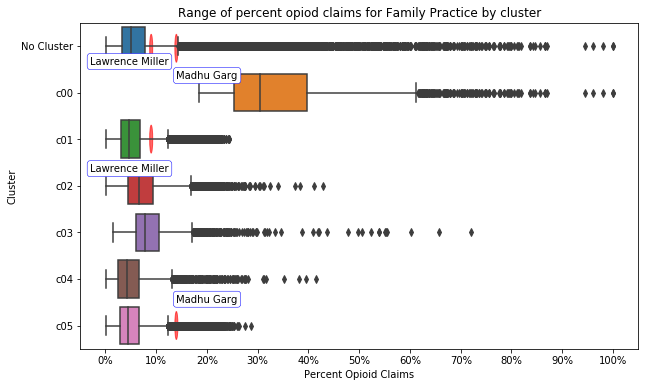

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,5.08,3.26,7.72,14.40,4917,77926,6.31
c00,30.40,25.29,39.70,61.31,139,2156,6.45
c01,4.63,3.08,6.78,12.31,1516,33966,4.46
c02,6.70,4.44,9.38,16.80,358,10192,3.51
c03,7.88,6.08,10.52,17.17,201,4126,4.87
c04,4.26,2.43,6.69,13.06,202,4060,4.98
c05,4.51,2.93,6.66,12.25,1161,23426,4.96


total number of Family Practice outliers with clustering:3577
total number of Family Practice outliers without clustering:4917


In [85]:
specility = 'Family Practice'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

c_list = sorted(copy_df['cluster'].unique())

#create figure
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

#For Madhu Garg

#Ellipse to mark datapoint examined for unclustered
ells = Circle((13.98, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#Ellipse to mark datapoint examined for clustered
ells = Circle((13.98, 6), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#add textbox to mark healthcare provider's name
text = 'Madhu Garg'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax.text(s=text,x=13.98,y=5.5,bbox=bbox_props)
ax.text(s=text,x=14,y=0.7
        ,bbox=bbox_props)

# For Lawrence Miller

#Ellipse to mark datapoint examined for unclustered
ells = Circle((9.01774, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#Ellipse to mark datapoint examined for clustered
ells = Circle((9.01774, 2), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#add textbox to mark healthcare provider's name
text = 'Lawrence Miller'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax.text(s=text,x=-3,y=2.7,bbox=bbox_props)
ax.text(s=text,x=-3,y=0.4
        ,bbox=bbox_props)

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax)
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()


#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

In [10]:
display(speciality_df['Family Practice'][speciality_df['Family Practice'].label.str.lower().str.contains('madhu') &
        speciality_df['Family Practice'].label.str.lower().str.contains('garg')])

display(speciality_df['Family Practice'][speciality_df['Family Practice'].label.str.lower().str.contains('miller') &
        speciality_df['Family Practice'].label.str.lower().str.contains('lawrence')]) 

,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income,label,cluster
312761,27,13.917526,34.0964,-117.9682,76571.0,18.120667,8.813,25.09,135612.5,MADHU GARG Baldwin Park CA 91706,c05


,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income,label,cluster
627862,549,9.01774,40.232,-75.3037,55138.0,14.013667,1.662,25.683,76203.833333,LAWRENCE MILLER Lansdale PA 19446,c01


# Does clustering help determine if Samson Orusa is an outlier?

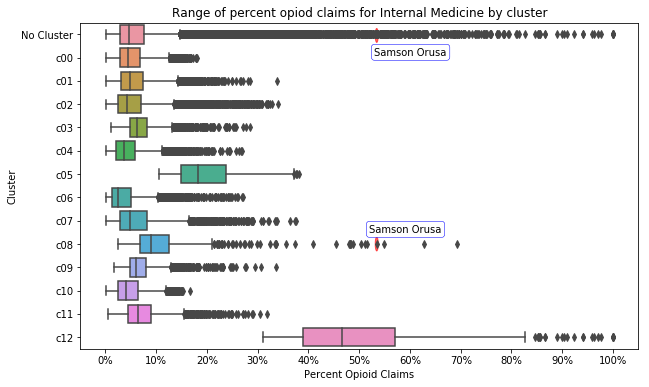

,median,1Q,3Q,top whisk,# outliers,# providers,% outliers
cluster,,,,,,,
No Cluster,4.74,2.85,7.56,14.62,4663,79871,5.84
c00,4.46,2.93,6.80,12.61,264,12693,2.08
c01,4.91,2.99,7.48,14.23,268,8528,3.14
c02,4.23,2.52,6.94,13.57,577,10406,5.54
c03,6.13,4.79,8.17,13.25,156,4156,3.75
c04,3.63,2.17,5.80,11.24,357,8019,4.45
c05,18.18,14.82,23.75,37.15,4,2966,0.13
c06,2.55,1.32,4.96,10.42,220,3949,5.57
c07,4.92,2.81,8.28,16.48,167,3989,4.19


total number of Internal Medicine outliers with clustering:2649
total number of Internal Medicine outliers without clustering:4663


In [27]:
specility = 'Internal Medicine'
this_df = speciality_df[specility]

#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])

c_list = sorted(copy_df['cluster'].unique())

#create figure
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

#Ellipse to mark datapoint examined for unclustered
ells = Circle((53.453556, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#Ellipse to mark datapoint examined for clustered
ells = Circle((53.453556, 9), radius=0.3,color='red')
ells.set_clip_box(ax.bbox)
ells.set_alpha(0.6)
ax.add_artist(ells)

#add textbox to mark healthcare provider's name
text = 'Samson Orusa'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax.text(s=text,x=52,y=8.5,bbox=bbox_props)
ax.text(s=text,x=53,y=0.9
        ,bbox=bbox_props)

sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = 'Range of percent opiod claims for ' + specility + ' by cluster'
plt.title(the_title)
plt.ylabel('Cluster')
plt.xlabel('Percent Opioid Claims')
figure_name = specility.replace(' ','_') + '.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()

#clustering table  
opioid_table = copy_df.groupby('cluster').median()[['percent opioid claims']]
opioid_table.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_table['1Q'] = copy_df.groupby('cluster').quantile(.25)['percent opioid claims']
opioid_table['3Q'] = copy_df.groupby('cluster').quantile(.75)['percent opioid claims']
opioid_table['top whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
                                                            x[1] + 1.5*(x[1]- x[0])
                                                            if x[1] + 1.5*(x[1]- x[0]) < 100
                                                            else 100,axis=1)

#bottom whisker calculated from IQR does not match boxplot and i don't know why. 
#It is remoeved
#opioid_table['bottom whisk'] = opioid_table[['1Q','3Q']].apply(lambda x:
#                                                               x[0] - 1.5*(x[1]- x[0]) 
#                                                               if x[0] - 1.5*(x[1]- x[0])  > 0
#                                                               else 0,axis=1)
#Count outliers
outliers =  pd.DataFrame()

max_value = opioid_table['top whisk']
#min_value = opioid_table['bottom whisk']
for n in c_list:
        df = copy_df[(copy_df['cluster']== n)
                      & (copy_df['percent opioid claims'] > max_value[n])]
#                     & ((this_df['percent opioid claims'] > max_value[n])
#                      | (this_df['percent opioid claims'] < min_value[n]))]
        outliers= pd.concat([outliers,df])
opioid_table['# outliers'] = outliers.groupby('cluster').count()['percent opioid claims']
opioid_table.fillna(0, inplace=True)
opioid_table['# outliers'] = opioid_table['# outliers'].astype(int)
opioid_table['# providers'] = copy_df.groupby('cluster').count()['percent opioid claims'].astype(int)
opioid_table['% outliers'] = opioid_table['# outliers']/opioid_table['# providers']*100
csv_name = specility.replace(' ','_') + '.csv'
opioid_table.round(2).to_csv(path_or_buf=csv_name)
display(opioid_table.round(2))
print('total number of {} outliers with clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index!='No Cluster']['# outliers'].sum()))
print('total number of {} outliers without clustering:{:.0f}'.format(
    specility,opioid_table[opioid_table.index=='No Cluster']['# outliers'].sum()))

In [24]:
display(speciality_df['Internal Medicine'][speciality_df['Internal Medicine'].label.str.lower().str.contains('samson') &
        speciality_df['Internal Medicine'].label.str.lower().str.contains('orusa')])

,opioid claims,percent opioid claims,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income,label,cluster
697077,3142,53.453556,36.5691,-87.417,151785.0,16.172444,4.823,24.51,107206.75,SAMSON ORUSA Clarksville TN 37042,c08


# The following cell exists only to create figure for documentation.

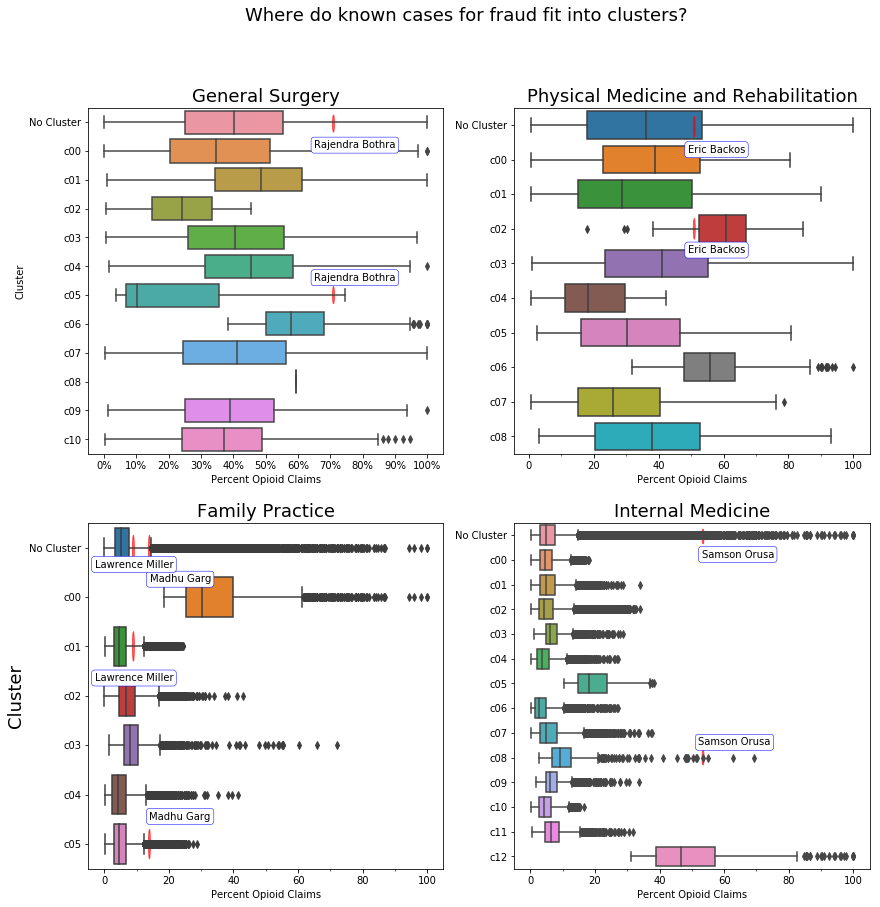

In [113]:
fig = plt.figure(figsize=(14,14))

plt.suptitle('Where do known cases for fraud fit into clusters?',size=18)


#Rajendra Bothra
ax1 = fig.add_subplot(2,2,1)
specility = 'General Surgery'
this_df = GS_df
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
#Ellipse to mark datapoint examined for unclustered
ells = Circle((71, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax1.bbox)
ells.set_alpha(0.6)
ax1.add_artist(ells)
#Ellipse to mark datapoint examined for clustered
ells = Circle((71, 6), radius=0.3,color='red')
ells.set_clip_box(ax1.bbox)
ells.set_alpha(0.6)
ax1.add_artist(ells)
#add textbox to mark healthcare provider's name
text = 'Rajendra Bothra'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax1.text(s=text,x=65,y=5.5,bbox=bbox_props)
ax1.text(s=text,x=65,y=0.9,bbox=bbox_props)
#boxplot
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax1)
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = specility
ax1.set_title(the_title,size=18)
ax1.set_ylabel('Cluster')
ax1.set_xlabel('Percent Opioid Claims')

#Eric Backos
ax2 = fig.add_subplot(2,2,2)
specility = 'Physical Medicine and Rehabilitation'
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
#Ellipse to mark datapoint examined for unclustered
ells = Circle((51, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax2.bbox)
ells.set_alpha(0.6)
ax2.add_artist(ells)
#Ellipse to mark datapoint examined for clustered
ells = Circle((51, 3), radius=0.3,color='red')
ells.set_clip_box(ax2.bbox)
ells.set_alpha(0.6)
ax2.add_artist(ells)
#add textbox to mark healthcare provider's name
text = 'Eric Backos'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax2.text(s=text,x=49,y=3.7,bbox=bbox_props)
ax2.text(s=text,x=49,y=0.8,bbox=bbox_props)
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax2)
#di = copy_df.boxplot(by='cluster',column=['percent opioid claims'],return_type='dict')
ax2.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = specility
ax2.set_title(the_title,size=18)
ax2.set_ylabel('')
ax2.set_xlabel('Percent Opioid Claims')

#For Madhu Garg and Lawrence Miller
specility = 'Family Practice'
ax3 = fig.add_subplot(2,2,3)
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
#For Madhu Garg
#Ellipse to mark datapoint examined for unclustered
ells = Circle((13.98, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax3.bbox)
ells.set_alpha(0.6)
ax3.add_artist(ells)
#Ellipse to mark datapoint examined for clustered
ells = Circle((13.98, 6), radius=0.3,color='red')
ells.set_clip_box(ax3.bbox)
ells.set_alpha(0.6)
ax3.add_artist(ells)
#add textbox to mark healthcare provider's name
text = 'Madhu Garg'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax3.text(s=text,x=13.98,y=5.5,bbox=bbox_props)
ax3.text(s=text,x=14,y=0.7
        ,bbox=bbox_props)
# For Lawrence Miller
#Ellipse to mark datapoint examined for unclustered
ells = Circle((9.01774, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax3.bbox)
ells.set_alpha(0.6)
ax3.add_artist(ells)
#Ellipse to mark datapoint examined for clustered
ells = Circle((9.01774, 2), radius=0.3,color='red')
ells.set_clip_box(ax3.bbox)
ells.set_alpha(0.6)
ax3.add_artist(ells)
#add textbox to mark healthcare provider's name
text = 'Lawrence Miller'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax3.text(s=text,x=-3,y=2.7,bbox=bbox_props)
ax3.text(s=text,x=-3,y=0.4
        ,bbox=bbox_props)
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax3)
ax3.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = specility
ax3.set_title(the_title,size=18)
ax3.set_ylabel('Cluster',size=18)
ax3.set_xlabel('Percent Opioid Claims')

#Samson Orusa
specility = 'Internal Medicine'
this_df = speciality_df[specility]
ax4 = fig.add_subplot(2,2,4)
this_df = speciality_df[specility]
#creating a copy of ever entry with cluster = 'no cluster'
#This copies is used to create a boxplot for all health care providers in the speciality 
copy_df = this_df.copy()
copy_df['cluster'] = 'No Cluster'
copy_df = pd.concat([this_df,copy_df])
c_list = sorted(copy_df['cluster'].unique())
#Ellipse to mark datapoint examined for unclustered
ells = Circle((53.453556, 0.05), radius=0.3,color='red')
ells.set_clip_box(ax4.bbox)
ells.set_alpha(0.6)
ax4.add_artist(ells)
#Ellipse to mark datapoint examined for clustered
ells = Circle((53.453556, 9), radius=0.3,color='red')
ells.set_clip_box(ax4.bbox)
ells.set_alpha(0.6)
ax4.add_artist(ells)
#add textbox to mark healthcare provider's name
text = 'Samson Orusa'
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=.5)
ax4.text(s=text,x=52,y=8.5,bbox=bbox_props)
ax4.text(s=text,x=53,y=0.9
        ,bbox=bbox_props)
sns.boxplot(y='cluster',x='percent opioid claims',data=copy_df,order=c_list,ax=ax4)
ax4.set_xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
the_title = specility
ax4.set_title(the_title,size=18)
ax4.set_ylabel('')
ax4.set_xlabel('Percent Opioid Claims')

figure_name ='outliers.jpg'
fig.savefig(figure_name,bbox_inches='tight')
plt.show()
